# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [6]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

debug: prev_h shape  (3, 5)
debug: H shape  5
debug: a   [[ 1.56210477  1.52884119  1.4955776   1.46231401  1.42905043  1.39578684
   1.36252325  1.32925967  1.29599608  1.26273249  1.22946891  1.19620532
   1.16294173  1.12967815  1.09641456  1.06315097  1.02988739  0.9966238
   0.96336021  0.93009663]
 [ 0.52201728  0.6412236   0.76042992  0.87963624  0.99884256  1.11804888
   1.2372552   1.35646152  1.47566784  1.59487416  1.71408048  1.8332868
   1.95249312  2.07169944  2.19090576  2.31011208  2.42931841  2.54852473
   2.66773105  2.78693737]
 [-0.51807021 -0.24639399  0.02528224  0.29695847  0.5686347   0.84031092
   1.11198715  1.38366338  1.65533961  1.92701583  2.19869206  2.47036829
   2.74204451  3.01372074  3.28539697  3.5570732   3.82874942  4.10042565
   4.37210188  4.64377811]]
debug: a shape  (3, 20)
debug: a_i shape  (3, 5)
debug: a_f shape  (3, 5)
next_h error:  5.7054131185818695e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-7` or less.

In [7]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99376607  

debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12118454  -1.71413718  -3.17811172  -5.74422      0.2443041
    0.61358981   3.15492537  -2.01351665  -1.11846923  -0.83527609
    3.56902464   1.04560784   1.84915933  -5.25036913   4.07103101
   -5.64726134   0.38169548   0.48391805   1.49718882  -2.49845533
   -1.26461551   3.9937667    1.42450204   2.58086377]
 [ 

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.8

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59587641   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004636   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352364  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.8

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84939887
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35219406
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49843185
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04201043   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17659194   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11848447  -0.83529211
    3.56903935   1.04561562   1.8

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84942091
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35222043
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.4984368
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.17

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76848023  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.43235642   5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17811719  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.8

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746871   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54773114  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26459812   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.9626134    1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766181  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25037304   4.07103275
   -5.64726097   0.381

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04201112   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17659086   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847502  -0.83529211
    3.56903935   1.04561562   1.8

   -4.02860223   2.09472195  -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.14110809   1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813838   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.8

debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.35100663   4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.47609252   5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15492386  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.5770455   -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486966   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.8

   -4.02860223   2.0947221   -2.81703728  -2.01214246]]
debug: a shape  (4, 24)
debug: a_i shape  (4, 6)
debug: a_f shape  (4, 6)
debug: prev_h shape  (4, 6)
debug: H shape  6
debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.327459     4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54773882  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.8

debug: a   [[ -2.03448674  -0.39496563   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521761   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71413982  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971493   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105187  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74422848   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57703788  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411171    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486084   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99813504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84914099  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99376607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

debug: a   [[ -2.03448674  -0.39497464   0.76849808  -4.19971261   2.07549655
    2.56066263  -3.3510146    4.59586244   0.04200968   1.40979718
    0.55021685  -3.73063169   2.57704585  -2.96261305   1.28103216
   -0.33509281   3.89847686   3.20563735   1.6489362   -5.84941673
   -5.32746162   4.1411071    1.52135173   3.26748135]
 [  1.41066795   1.17521427   2.4323378    5.63105462  -3.22124876
   -2.0841735   -1.4760849    5.15004786   2.17658817   1.95674817
    1.35233828   3.9066643   -4.57486846   1.88766301  -1.56485421
    2.43230867 -10.39538679  -2.24047673  -2.3179696    2.35221268
    2.54774539  -3.99814504   3.34448721   2.15021873]
 [ -2.12119493  -1.71414105  -3.17810882  -5.74424277   0.24429445
    0.61360301   3.15493089  -2.01352659  -1.11847117  -0.83529211
    3.56903935   1.04561562   1.84913396  -5.25038      4.07103275
   -5.64726097   0.38169356   0.48392117   1.49718176  -2.49844022
   -1.26460765   3.99375607   1.42450815   2.5808649 ]
 [  6.13594067   0.1

# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [9]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

debug: prev_h shape  (2, 4)
debug: H shape  4
debug: a   [[0.04179086 0.04391422 0.04603759 0.04816095 0.05028431 0.05240768
  0.05453104 0.0566544  0.05877777 0.06090113 0.06302449 0.06514786
  0.06727122 0.06939458 0.07151795 0.07364131]
 [0.79443572 0.87175324 0.94907075 1.02638826 1.10370578 1.18102329
  1.2583408  1.33565831 1.41297583 1.49029334 1.56761085 1.64492837
  1.72224588 1.79956339 1.8768809  1.95419842]]
debug: a shape  (2, 16)
debug: a_i shape  (2, 4)
debug: a_f shape  (2, 4)
debug: prev_h shape  (2, 4)
debug: H shape  4
debug: a   [[0.08591619 0.1092652  0.13261421 0.15596322 0.17931224 0.20266125
  0.22601026 0.24935927 0.27270828 0.29605729 0.3194063  0.34275531
  0.36610432 0.38945334 0.41280235 0.43615136]
 [0.82029837 0.9062832  0.99226803 1.07825285 1.16423768 1.25022251
  1.33620734 1.42219216 1.50817699 1.59416182 1.68014664 1.76613147
  1.8521163  1.93810113 2.02408595 2.11007078]]
debug: a shape  (2, 16)
debug: a_i shape  (2, 4)
debug: a_f shape  (2, 4)
debu

# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [10]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588915e+00  3.69061114e+00  8.61107214e-01 -9.55248204e+00
  -1.41483636e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.63053085e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863021e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360526e+00 -7.50961678e-01 -1.66561259e+00 -3.50919993e+00
  -2.31513770e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312191 -0.

debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734932 -1.54943349 -0.70840426  2.68238284  0.90799824  0.59637906
  -1.62136271  0.27439777 -0.79723498  1.63607225 -0.85174937 -0.02175332
  -2.61312571 -2.39834244 -0.42917917  0.25850583 -1.53613163 -1.40550382
  -0.40167404  0.26229595  0.27540639  1.29107598 -0.21629623  1.01885262]
 [ 2.58514067 -1.03920789 -1.15867836 -0.64502488  0.05440687  1.82196955
  -3.3049144   0.64220143  5.56233234  0.07907763  0.81031813 -1.5005127
  -1.71650273 -0.74221663  1.17794952 -0.92129571  2.69756505  0.96378103
   1.91933081  1.1571734   2.60719941  1.57218701 -0.25137075  5.3133308 ]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923208 -1.3874794   0.51521053  1.38974446  0.78407748  1.79587022
  -1.29239593 -1.84943124  2.01465705  1.01837545  0.34394317 -0.59272364
   0.60200778 -1.15050177  0.37313894 -0.40035147 -1.59859516 -0.82705

  -0.06257821  3.10708114  1.57996215  1.14573112  2.42771548  4.36461436]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298028e+00 -1.37941598e+00 -9.09366409e-01  1.56963440e+00
   9.39306815e-01  1.60529512e+00 -1.51792023e+00  7.44604275e-02
   2.53345746e+00  1.40163772e+00  6.62804729e-01 -1.73889105e+00
  -9.10096484e-01 -1.05526424e+00 -1.27580467e-01 -3.99731045e-01
   8.31816192e-01 -6.99617207e-01  5.70158076e-03 -1.02202855e-02
   7.18896191e-01  8.77747985e-01 -1.49716154e-01  2.69270438e+00]
 [ 3.50045869e+00 -4.62190480e-01  9.73661129e-01 -1.94722452e+00
  -9.48065325e-01  4.20732435e+00 -2.53133611e+00 -2.09848119e+00
   7.91302013e+00 -1.42342975e+00  1.15803191e+00  1.59200376e-02
   7.90118771e-01  2.73775609e-02  3.16245694e+00 -2.70944288e+00
   5.73147594e-01  1.72854596e+00  3.37061718e+00  3.70273420e+00
   3.17838506e+00  1.14611068e+00  1.95596164e+00  4.40366517e+00]

   3.17838506e+00  1.14611068e+00  1.95596164e+00  4.40366517e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588915e+00  3.69061114e+00  8.61107214e-01 -9.55248204e+00
  -1.41483636e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.63053085e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863021e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360526e+00 -7.50961678e-01 -1.66561259e+00 -3.50919993e+00
  -2.31513770e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug:

debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 8.44507947e-01 -1.99555494e+00  4.75785304e-01  1.54930010e+00
   6.40033227e-01 -7.54363114e-01 -3.13828919e+00 -9.16967646e-01
   9.76123892e-02  6.84349339e-01 -2.77594336e-01 -1.09142572e+00
   2.16682015e-03 -3.68083346e+00 -4.15545909e-01  7.22377844e-01
  -2.30145829e+00 -2.76032298e-01 -6.65215628e-01  6.10412247e-01
  -2.63023566e+00 -1.53336434e-01 -1.10841190e+00 -9.23816942e-02]
 [ 1.04131056e+00 -2.42272481e+00 -1.33577793e+00 -8.85998176e-02
  -6.57818636e-01 -4.94165109e+00 -6.73423265e+00  9.97575131e-01
  -7.26984164e-01 -6.20923360e-01 -2.04843553e+00 -2.05527750e-01
  -2.53060970e+00 -4.79193800e+00  2.32063955e-01 -4.90786830e-03
  -3.28022684e+00  2.59564275e+00 -1.33885707e+00 -1.25698699e-01
  -3.15942045e+00  1.05928929e+00 -4.36373724e+00  6.76802830e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82946244 -1.

debug: a   [[ 8.44507947e-01 -1.99555494e+00  4.75785304e-01  1.54930010e+00
   6.40033227e-01 -7.54363114e-01 -3.13828919e+00 -9.16967646e-01
   9.76123892e-02  6.84349339e-01 -2.77594336e-01 -1.09142572e+00
   2.16682015e-03 -3.68083346e+00 -4.15545909e-01  7.22377844e-01
  -2.30145829e+00 -2.76032298e-01 -6.65215628e-01  6.10412247e-01
  -2.63023566e+00 -1.53336434e-01 -1.10841190e+00 -9.23816942e-02]
 [ 1.04131056e+00 -2.42272481e+00 -1.33577793e+00 -8.85998176e-02
  -6.57818636e-01 -4.94165109e+00 -6.73423265e+00  9.97575131e-01
  -7.26984164e-01 -6.20923360e-01 -2.04843553e+00 -2.05527750e-01
  -2.53060970e+00 -4.79193800e+00  2.32063955e-01 -4.90786830e-03
  -3.28022684e+00  2.59564275e+00 -1.33885707e+00 -1.25698699e-01
  -3.15942045e+00  1.05928929e+00 -4.36373724e+00  6.76802830e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945266 -1.44217199 -1.49635743  2.08817364  0.56539413  

debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034255 -0.84276792  1.20316682
  -2.11869392 -2.89886427  6.73794416 -1.48810064  1.6520292  -0.44930279
   3.60111975  1.20852086  1.94922747 -6.23656508 -1.61724628  3.10490372
  -0.94150785  0.19909853  1.04659203  1.98811384  0.89565263  5.17781271]
 [ 2.87623233 -0.7151259  -1.76644477  0.55617863  0.28271706  3.53202663
  -1.20762839 -1.42436555  6.27974342  0.30836822  1.62610153 -0.73338458
   1.28620659  0.8102552   0.87821015 -2.94121378  2.23107078  0.36145924
   1.08685189  0.52734869  2.74322914  1.6795047   1.9737681   5.42972435]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.4564299  -0.93438852 -0.32436688  1.29337649  0.44506596  2.2784287
  -2.0960806  -0.54356543  1.95252665  0.49908035 -0.38721986  0.88050084
  -2.71934359 -1.76190341  0.82069335 -0.26042439 -0.45276224 -0.91845362
   2.18439306  2.69336822  2.07740269  2.0

debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298023e+00 -1.37941598e+00 -9.09366461e-01  1.56963454e+00
   9.39306869e-01  1.60529523e+00 -1.51792007e+00  7.44603974e-02
   2.53345733e+00  1.40163781e+00  6.62804706e-01 -1.73889096e+00
  -9.10096538e-01 -1.05526420e+00 -1.27580544e-01 -3.99731066e-01
   8.31816208e-01 -6.99617359e-01  5.70158934e-03 -1.02203101e-02
   7.18896239e-01  8.77748041e-01 -1.49716029e-01  2.69270437e+00]
 [ 3.50045897e+00 -4.62190648e-01  9.73661369e-01 -1.94722563e+00
  -9.48065790e-01  4.20732359e+00 -2.53133735e+00 -2.09848126e+00
   7.91302095e+00 -1.42343033e+00  1.15803176e+00  1.59201224e-02
   7.90119404e-01  2.73772059e-02  3.16245727e+00 -2.70944282e+00
   5.73147796e-01  1.72854695e+00  3.37061730e+00  3.70273422e+00
   3.17838449e+00  1.14611038e+00  1.95596101e+00  4.40366505e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)


debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 8.44507947e-01 -1.99555494e+00  4.75785304e-01  1.54930010e+00
   6.40033227e-01 -7.54363114e-01 -3.13828919e+00 -9.16967646e-01
   9.76123892e-02  6.84349339e-01 -2.77594336e-01 -1.09142572e+00
   2.16682015e-03 -3.68083346e+00 -4.15545909e-01  7.22377844e-01
  -2.30145829e+00 -2.76032298e-01 -6.65215628e-01  6.10412247e-01
  -2.63023566e+00 -1.53336434e-01 -1.10841190e+00 -9.23816942e-02]
 [ 1.04131115e+00 -2.42272472e+00 -1.33578055e+00 -8.85976630e-02
  -6.57818919e-01 -4.94164670e+00 -6.73423178e+00  9.97570991e-01
  -7.26988106e-01 -6.20924354e-01 -2.04843947e+00 -2.05515717e-01
  -2.53061618e+00 -4.79194015e+00  2.32062547e-01 -4.91053541e-03
  -3.28022615e+00  2.59563850e+00 -1.33884763e+00 -1.25691889e-01
  -3.15941802e+00  1.05929566e+00 -4.36372893e+00  6.76807093e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945266 -1.

  -3.15941741e+00  1.05928748e+00 -4.36373311e+00  6.76790538e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945266 -1.44217199 -1.49635743  2.08817364  0.56539413  0.27006266
  -1.85578561 -1.457857    1.98647629  0.45863158  0.74042156 -1.20162079
   1.21063801 -1.56931147 -0.18734293 -2.04141377 -1.67268063  0.25725479
  -1.30575396 -0.28910766 -0.94507806  0.88566268  0.04170602  2.46339786]
 [ 3.61780891 -0.3963347  -1.62081968  0.5294525   0.40085261  2.85524345
  -2.23069586 -0.60331956  6.59432419 -0.4126493   2.27912616 -2.1271272
   0.26563821 -0.33073796  1.1526863  -1.96976694  2.19324069  0.71702142
   1.53891541  1.4606516   3.44230979  1.67106986  1.65291139  7.24081881]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734945 -1.54943343 -0.70840413  2.68238261  0.90799814  0.59637884
  

debug: a   [[ 1.82945266 -1.44217199 -1.49635743  2.08817364  0.56539413  0.27006266
  -1.85578561 -1.457857    1.98647629  0.45863158  0.74042156 -1.20162079
   1.21063801 -1.56931147 -0.18734293 -2.04141377 -1.67268063  0.25725479
  -1.30575396 -0.28910766 -0.94507806  0.88566268  0.04170602  2.46339786]
 [ 3.61780741 -0.39633518 -1.62082011  0.52945083  0.40085092  2.85524435
  -2.23069615 -0.60331855  6.59432375 -0.4126484   2.27912276 -2.12712196
   0.26563725 -0.33073657  1.15268689 -1.96976825  2.19324245  0.71702204
   1.53891526  1.46064888  3.44231245  1.6710708   1.65291188  7.24081692]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734945 -1.54943343 -0.70840413  2.68238261  0.90799814  0.59637884
  -1.621363    0.27439793 -0.79723474  1.63607204 -0.85174928 -0.0217536
  -2.61312575 -2.39834254 -0.42917893  0.25850591 -1.53613179 -1.40550352
  -0.40167407  0.26229608  0.27540649  1.2

debug: a   [[ 1.31298023e+00 -1.37941598e+00 -9.09366461e-01  1.56963454e+00
   9.39306869e-01  1.60529523e+00 -1.51792007e+00  7.44603974e-02
   2.53345733e+00  1.40163781e+00  6.62804706e-01 -1.73889096e+00
  -9.10096538e-01 -1.05526420e+00 -1.27580544e-01 -3.99731066e-01
   8.31816208e-01 -6.99617359e-01  5.70158934e-03 -1.02203101e-02
   7.18896239e-01  8.77748041e-01 -1.49716029e-01  2.69270437e+00]
 [ 3.50046375e+00 -4.62192643e-01  9.73667661e-01 -1.94724721e+00
  -9.48073284e-01  4.20730795e+00 -2.53135688e+00 -2.09847543e+00
   7.91304056e+00 -1.42343929e+00  1.15803445e+00  1.59052740e-02
   7.90129980e-01  2.73763444e-02  3.16246680e+00 -2.70944127e+00
   5.73149632e-01  1.72856859e+00  3.37061163e+00  3.70273044e+00
   3.17837557e+00  1.14610063e+00  1.95593952e+00  4.40366125e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+

debug: H shape  6
debug: a   [[ 1.31298023e+00 -1.37941598e+00 -9.09366431e-01  1.56963449e+00
   9.39306828e-01  1.60529521e+00 -1.51792013e+00  7.44604239e-02
   2.53345735e+00  1.40163779e+00  6.62804674e-01 -1.73889093e+00
  -9.10096525e-01 -1.05526422e+00 -1.27580506e-01 -3.99731060e-01
   8.31816195e-01 -6.99617303e-01  5.70156933e-03 -1.02203355e-02
   7.18896278e-01  8.77748023e-01 -1.49716047e-01  2.69270435e+00]
 [ 3.50045869e+00 -4.62190480e-01  9.73661129e-01 -1.94722452e+00
  -9.48065325e-01  4.20732435e+00 -2.53133611e+00 -2.09848119e+00
   7.91302013e+00 -1.42342975e+00  1.15803191e+00  1.59200376e-02
   7.90118771e-01  2.73775609e-02  3.16245694e+00 -2.70944288e+00
   5.73147594e-01  1.72854596e+00  3.37061718e+00  3.70273420e+00
   3.17838506e+00  1.14611068e+00  1.95596164e+00  4.40366517e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38075376e-01 -1.47839635e+00 -2.78198600

debug: a   [[ 1.53312191 -0.58276225 -1.18632688  1.80431198  0.63570318  4.18973684
   0.22731933 -1.85198091  4.06424026  1.26999965  0.76395817  0.71039091
   0.9442389   1.27764577  0.76341382 -2.41879908  0.48283177 -1.02240766
   0.48023597  0.71318623  2.80743299  1.74790488  2.62743875  2.85049869]
 [ 0.34266306 -1.27075655 -0.52942582  2.16963954  0.65928771  2.31963129
  -0.4802023  -1.31995326  0.87634862  1.65380314 -0.65478163  1.2031538
  -0.63062563 -0.42707599  0.21044229 -1.16735374 -1.45024026 -1.36225058
  -0.0775393   0.63396513  0.62691687  1.39877375  1.02723588  0.17698716]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034255 -0.84276792  1.20316682
  -2.11869392 -2.89886427  6.73794416 -1.48810064  1.6520292  -0.44930279
   3.60111975  1.20852086  1.94922747 -6.23656508 -1.61724628  3.10490372
  -0.94150785  0.19909853  1.04659203  1.9

   1.91933102  1.15717355  2.60719922  1.57218698 -0.25137071  5.31333085]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923212 -1.38747939  0.5152106   1.3897444   0.78407742  1.79587017
  -1.29239603 -1.84943122  2.01465708  1.01837537  0.34394316 -0.59272364
   0.60200782 -1.15050186  0.373139   -0.40035145 -1.59859523 -0.82705538
   0.25339519  1.56685643 -1.03759921  0.35050759  0.29493848 -0.03854153]
 [ 4.75093078  0.30897394 -0.57281475 -0.92841778 -1.25550244  3.154153
  -1.42792625 -5.23307411  9.51786234 -2.88426854  2.99162004 -0.76167342
   6.39598935  2.27153032  4.03189338 -6.89425408 -3.84466478  3.79035802
  -0.06257804  3.10708122  1.57996205  1.14573113  2.42771546  4.36461437]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298023e+00 -1.37941598e+00 -9.09366461e-01  1.56963454e+00
   

debug: a   [[ 1.11059606 -2.34904895 -1.91364187  0.76969101  0.61144795 -0.6501425
  -4.33531056  1.23212368  1.00625892  1.27844697 -1.02351782 -0.10666914
  -3.08377105 -3.46922007 -1.37256595  0.84868692  2.80329008 -0.41161585
   1.20012548 -0.59400203 -0.57564977  1.5442267  -1.26637093  3.49142352]
 [ 2.574879   -1.60176101 -1.62191804 -0.36585426 -0.19880945  1.10239508
  -3.28329653 -2.27611268  4.52272359 -0.50243375  0.19313274  0.74879058
   0.47066534 -1.04264183  0.57817356 -2.82422628  0.49721992  1.10612388
   2.03691409  1.80740988 -0.88752085  1.90323884  0.3918162   3.5030333 ]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 8.44508098e-01 -1.99555503e+00  4.75785290e-01  1.54929507e+00
   6.40033467e-01 -7.54363197e-01 -3.13828916e+00 -9.16968107e-01
   9.76123846e-02  6.84349293e-01 -2.77593987e-01 -1.09142607e+00
   2.16730215e-03 -3.68083372e+00 -4.15546250e-01  7.22377933e-01


debug: a   [[ 1.82945278 -1.44217197 -1.49635739  2.08817366  0.56539419  0.27006256
  -1.8557857  -1.45785708  1.98647637  0.4586327   0.74042174 -1.20162105
   1.21063808 -1.5693116  -0.18734293 -2.04141369 -1.67268073  0.25725481
  -1.3057539  -0.28910744 -0.94507824  0.88566263  0.04170597  2.463398  ]
 [ 3.61780819 -0.39633496 -1.62081989  0.52945096  0.40085117  2.85524385
  -2.23069679 -0.60331902  6.59432406 -0.4126668   2.2791236  -2.12712301
   0.26563729 -0.33073752  1.15268698 -1.9697678   2.19324172  0.71702219
   1.53891595  1.46065043  3.44231179  1.67107074  1.65291193  7.24081798]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734946 -1.54943344 -0.70840413  2.68238263  0.90799816  0.59637885
  -1.62136298  0.27439788 -0.79723476  1.63607466 -0.85174926 -0.0217536
  -2.61312572 -2.39834256 -0.42917896  0.25850591 -1.53613178 -1.40550355
  -0.40167404  0.2622961   0.27540642  1.2

  -3.15941992e+00  1.05928948e+00 -4.36373700e+00  6.76802579e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945237 -1.44217192 -1.49635764  2.08817473  0.56539477  0.2700632
  -1.85578431 -1.45785696  1.98647571  0.45863228  0.74042208 -1.20162166
   1.21063795 -1.56931096 -0.18734217 -2.04141373 -1.6726807   0.25725387
  -1.30575449 -0.28910799 -0.94507812  0.88566261  0.0417062   2.4633977 ]
 [ 3.61780702 -0.39633571 -1.62082028  0.5294509   0.40085103  2.85524455
  -2.23069577 -0.60331927  6.59432353 -0.4126478   2.27912252 -2.12712134
   0.26563859 -0.33073641  1.15266845 -1.96976853  2.1932433   0.71702162
   1.53891497  1.46064778  3.44231106  1.67107045  1.65291211  7.24081591]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734924 -1.54943347 -0.70840425  2.68238295  0.9079983   0.5963791
  -

debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340971 -0.63528462 -2.84106113  0.08033576 -0.84277006  1.20316146
  -2.11870007 -2.89886178  6.73795071 -1.48810334  1.65203061 -0.4493089
   3.60112311  1.20852108  1.94923074 -6.23656417 -1.61724586  3.10491083
  -0.94150895  0.19909708  1.04658943  1.98811046  0.89564495  5.17781145]
 [ 2.87623177 -0.71512605 -1.76644532  0.55617978  0.28271743  3.53202764
  -1.20762721 -1.42436619  6.27974216  0.30836905  1.62610098 -0.73338292
   1.28620651  0.8102554   0.87820922 -2.94121405  2.23107123  0.36145784
   1.08686646  0.5273483   2.74322919  1.67950525  1.97376953  5.42972402]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.456429   -0.93438881 -0.32436742  1.29337712  0.4450663   2.27842887
  -2.09607999 -0.54356572  1.95252591  0.49908147 -0.3872203   0.88050

debug: a   [[ 8.44508049e-01 -1.99555487e+00  4.75785585e-01  1.54929978e+00
   6.40032929e-01 -7.54363292e-01 -3.13828961e+00 -9.16967416e-01
   9.76125015e-02  6.84349048e-01 -2.77594520e-01 -1.09142558e+00
   2.16675441e-03 -3.68083374e+00 -4.15545552e-01  7.22377922e-01
  -2.30145855e+00 -2.76031894e-01 -6.65215708e-01  6.10412247e-01
  -2.63023521e+00 -1.53336535e-01 -1.10841196e+00 -9.23763739e-02]
 [ 1.04131066e+00 -2.42272482e+00 -1.33577777e+00 -8.85999607e-02
  -6.57818766e-01 -4.94165121e+00 -6.73423293e+00  9.97575055e-01
  -7.26984126e-01 -6.20923561e-01 -2.04843560e+00 -2.05527618e-01
  -2.53060953e+00 -4.79193831e+00  2.32064026e-01 -4.90780852e-03
  -3.28022697e+00  2.59564292e+00 -1.33885703e+00 -1.25698633e-01
  -3.15942048e+00  1.05928919e+00 -4.36373717e+00  6.76815603e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945335 -1.44217131 -1.49635711  2.08817302  0.56539366  

debug: a   [[ 1.31298022e+00 -1.37941599e+00 -9.09366393e-01  1.56963174e+00
   9.39306767e-01  1.60529520e+00 -1.51792019e+00  7.44604421e-02
   2.53345735e+00  1.40163776e+00  6.62804600e-01 -1.73889082e+00
  -9.10096506e-01 -1.05526426e+00 -1.27580472e-01 -3.99731065e-01
   8.31816187e-01 -6.99617252e-01  5.70155296e-03 -1.02203863e-02
   7.18896341e-01  8.77748009e-01 -1.49716027e-01  2.69270432e+00]
 [ 3.50045888e+00 -4.62190492e-01  9.73661288e-01 -1.94721784e+00
  -9.48065493e-01  4.20732415e+00 -2.53133646e+00 -2.09848115e+00
   7.91302044e+00 -1.42343003e+00  1.15803194e+00  1.59198705e-02
   7.90118767e-01  2.73773998e-02  3.16245717e+00 -2.70944292e+00
   5.73147507e-01  1.72854632e+00  3.37061731e+00  3.70273438e+00
   3.17838499e+00  1.14611060e+00  1.95596140e+00  4.40366528e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+

debug: a   [[ 1.31298023e+00 -1.37941599e+00 -9.09366468e-01  1.56963455e+00
   9.39306877e-01  1.60529524e+00 -1.51792006e+00  7.44576912e-02
   2.53345733e+00  1.40163782e+00  6.62804709e-01 -1.73889095e+00
  -9.10096535e-01 -1.05526420e+00 -1.27580558e-01 -3.99731073e-01
   8.31816215e-01 -6.99617375e-01  5.70159911e-03 -1.02203070e-02
   7.18896221e-01  8.77748045e-01 -1.49716018e-01  2.69270437e+00]
 [ 3.50045855e+00 -4.62190427e-01  9.73660971e-01 -1.94722392e+00
  -9.48065112e-01  4.20732481e+00 -2.53133550e+00 -2.09847426e+00
   7.91301960e+00 -1.42342948e+00  1.15803186e+00  1.59203520e-02
   7.90118453e-01  2.73776322e-02  3.16245669e+00 -2.70944295e+00
   5.73147536e-01  1.72854536e+00  3.37061729e+00  3.70273427e+00
   3.17838532e+00  1.14611093e+00  1.95596218e+00  4.40366525e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+

debug: a   [[ 1.53312195 -0.58276228 -1.18632681  1.80431191  0.63570312  4.1897369
   0.22731935 -1.85198093  4.0642403   1.26999961  0.76395814  0.71039091
   0.94423886  1.27764648  0.76341386 -2.41879919  0.48283175 -1.02240762
   0.48023604  0.71318624  2.80743297  1.74790486  2.62743875  2.85049869]
 [ 0.342663   -1.27075734 -0.52942502  2.16963682  0.65928667  2.31963019
  -0.48020342 -1.3199525   0.87635085  1.65380302 -0.65478174  1.20315221
  -0.63062383 -0.42707134  0.21044302 -1.16735447 -1.45023922 -1.36224825
  -0.0775407   0.63396286  0.62691532  1.39877214  1.02723306  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340829 -0.63528423 -2.84106305  0.08034243 -0.84276797  1.20316678
  -2.118694   -2.89886425  6.73794424 -1.4881007   1.65202919 -0.44930282
   3.60111977  1.20850221  1.94922753 -6.23656511 -1.61724629  3.10490382
  -0.94150785  0.19909852  1.04659202  1.9

debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312183 -0.58276223 -1.18632698  1.80431234  0.63570329  4.18973713
   0.22731966 -1.85198105  4.06423992  1.26999979  0.76395809  0.71039123
   0.94423872  1.27764576  0.76341365 -2.41879913  0.48283175 -1.02240804
   0.48023686  0.7131863   2.80743313  1.74790506  2.62743916  2.85049876]
 [ 0.34266258 -1.27075709 -0.52942565  2.16963822  0.6592873   2.31963068
  -0.48020264 -1.31995278  0.87634968  1.65380363 -0.65478182  1.20315309
  -0.63062412 -0.42707502  0.21044234 -1.16735403 -1.4502392  -1.36224954
  -0.07753684  0.63396302  0.62691582  1.39877275  1.0272342   0.17698552]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340831 -0.63528428 -2.84106297  0.08034202 -0.84276808  1.20316646
  -2.1186943  -2.89886406  6.73794466 -1.48810076  1.65202929 -0.4493

debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945138 -1.44217172 -1.49635833  2.08817554  0.56539449  0.27006483
  -1.85578295 -1.45785639  1.98647413  0.45863325  0.74042035 -1.20161841
   1.21063581 -1.56931002 -0.18734339 -2.04141442 -1.67268032  0.25725269
  -1.30575407 -0.2891086  -0.94507532  0.88566403  0.04169791  2.46339751]
 [ 3.6178103  -0.39633401 -1.62081886  0.52944921  0.40085039  2.85524184
  -2.23070027 -0.60331843  6.59432597 -0.41265234  2.27912457 -2.12712478
   0.26563572 -0.33073972  1.15268926 -1.96976675  2.19323953  0.71702468
   1.5389177   1.46065442  3.44231288  1.67107096  1.65290167  7.24082101]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734939 -1.5494336  -0.70840298  2.68238239  0.90799776  0.59637836
  -1.6213633   0.27439818 -0.79723479  1.63607196 -0.85174921 -0.0217544
  -2.61312393 -2.39834337 -0.42917882  0.25850636 -1.53613242 -1.40550

debug: a   [[ 1.1105958  -2.34904916 -1.91364163  0.76968303  0.61146142 -0.65014246
  -4.3353101   1.23212347  1.00625858  1.27844741 -1.02351766 -0.1066695
  -3.08376988 -3.46922017 -1.37256645  0.84868707  2.80329013 -0.41161615
   1.20012458 -0.59400306 -0.57565043  1.54422604 -1.26637084  3.49142279]
 [ 2.57487876 -1.60176093 -1.62191704 -0.36585795 -0.19881219  1.10239476
  -3.283297   -2.27611175  4.52272345 -0.50243387  0.19313217  0.74879071
   0.470666   -1.04264231  0.57817425 -2.82422592  0.49721924  1.10612473
   2.03691256  1.80740839 -0.8875195   1.90323794  0.39181597  3.50303256]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 8.44508150e-01 -1.99555538e+00  4.75789148e-01  1.54930053e+00
   6.40041330e-01 -7.54364091e-01 -3.13828952e+00 -9.16967658e-01
   9.76114198e-02  6.84348855e-01 -2.77593652e-01 -1.09142829e+00
   2.17248131e-03 -3.68083710e+00 -4.15546019e-01  7.22379316e-01


debug: a   [[ 1.4564299  -0.93438852 -0.32436688  1.29337649  0.44506596  2.27842869
  -2.0960806  -0.54356542  1.95252665  0.4990833  -0.38721986  0.88050085
  -2.7193436  -1.7619034   0.82069335 -0.26042438 -0.45276224 -0.91845362
   2.18439306  2.69336823  2.0774027   2.00046762  1.26547011  2.95496351]
 [ 1.36652714 -0.77729833  0.28636368 -1.24784144  0.46483722  3.96669264
  -2.12486044 -0.07672598  5.64411332  0.90929801  0.20251227 -0.0334988
  -3.20475801  0.89871049  1.93834713  0.26429362  2.81401701 -0.56656845
   4.27379892  3.94785805  2.8207562   1.93730918  0.21311294  2.55748351]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059584 -2.34904885 -1.91364189  0.7696824   0.61144769 -0.65014237
  -4.33531052  1.23212424  1.00625891  1.27846038 -1.02351823 -0.10666873
  -3.08377163 -3.46921969 -1.37256557  0.84868679  2.80329012 -0.41161565
   1.20012529 -0.59400238 -0.57564882  1.5

debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.4564301  -0.93438863 -0.32436659  1.29337606  0.44506571  2.27842872
  -2.09608072 -0.54356541  1.95252696  0.4990801  -0.38721988  0.88050066
  -2.71934365 -1.76190651  0.82069359 -0.2604247  -0.45276233 -0.91845326
   2.18439324  2.69336828  2.07740257  2.00046746  1.2654699   2.95496352]
 [ 1.36652727 -0.77729853  0.28636393 -1.24784172  0.464837    3.96669302
  -2.12486015 -0.07672611  5.64411346  0.90929808  0.20251216 -0.03349878
  -3.20475819  0.89871057  1.93834721  0.26429301  2.81401702 -0.56656835
   4.27379927  3.94785804  2.82075598  1.9373091   0.21311295  2.55748345]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059596 -2.34904881 -1.9136419   0.7696825   0.61144781 -0.65014264
  -4.33531082  1.23212403  1.00625892  1.27844694 -1.02351804 -0.1066

  -0.06255345  3.10708093  1.57996234  1.14573089  2.4277155   4.3646143 ]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298006e+00 -1.37941579e+00 -9.09367108e-01  1.56963618e+00
   9.39307404e-01  1.60529657e+00 -1.51791877e+00  7.44596337e-02
   2.53345576e+00  1.40163823e+00  6.62804337e-01 -1.73888916e+00
  -9.10097834e-01 -1.05526439e+00 -1.27581273e-01 -3.99731322e-01
   8.31816062e-01 -6.99619142e-01  5.69951043e-03 -1.02192576e-02
   7.18896971e-01  8.77749246e-01 -1.49713939e-01  2.69270514e+00]
 [ 3.50046931e+00 -4.62193329e-01  9.73675513e-01 -1.94727356e+00
  -9.48080787e-01  4.20728543e+00 -2.53138064e+00 -2.09846305e+00
   7.91306757e+00 -1.42344940e+00  1.15804222e+00  1.58755453e-02
   7.90142946e-01  2.73790967e-02  3.16248073e+00 -2.70943616e+00
   5.73150432e-01  1.72859745e+00  3.37060886e+00  3.70272399e+00
   3.17836641e+00  1.14608620e+00  1.95590606e+00  4.40365628e+00]

debug: a   [[ 0.31734925 -1.54943349 -0.70840406  2.68238243  0.90799805  0.5963787
  -1.62136302  0.27439818 -0.79723465  1.63607223 -0.85174937 -0.02175374
  -2.61312539 -2.3983423  -0.4291789   0.25850597 -1.53613163 -1.40550333
  -0.40167463  0.26229542  0.27540652  1.29107562 -0.21630582  1.0188523 ]
 [ 2.58514071 -1.03920785 -1.15867906 -0.64502517  0.05440693  1.82196959
  -3.30491462  0.64220132  5.56233267  0.07907757  0.81031795 -1.50051208
  -1.71650365 -0.74221608  1.17794956 -0.92129598  2.69756563  0.96378099
   1.91933183  1.15717424  2.6071994   1.57218785 -0.25137116  5.31333125]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923224 -1.3874795   0.51521232  1.38974462  0.78407705  1.79586973
  -1.29239622 -1.84943112  2.01465661  1.01837509  0.34394344 -0.59272475
   0.60201011 -1.15050352  0.37313907 -0.40035074 -1.5985966  -0.82705488
   0.25339313  1.56685484 -1.03759934  0.3

   1.53891509  1.4606486   3.44231345  1.67107099  1.65291172  7.24081684]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.3173494  -1.54943346 -0.70840417  2.6823878   0.90799818  0.59637893
  -1.62136288  0.27439784 -0.79723484  1.63607212 -0.85174931 -0.02175349
  -2.61312571 -2.39834252 -0.42917904  0.25850588 -1.53613173 -1.40550365
  -0.40167405  0.26229603  0.27540642  1.29107591 -0.21629637  1.0188527 ]
 [ 2.5851407  -1.03920787 -1.15867827 -0.6450286   0.05440684  1.82196971
  -3.30491428  0.64220139  5.56233217  0.07907759  0.81031806 -1.50051253
  -1.71650286 -0.74221679  1.17794953 -0.92129576  2.69756489  0.96378093
   1.9193309   1.15717349  2.60719959  1.57218705 -0.2513705   5.31333089]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923212 -1.3874794   0.51521057  1.38974467  0.78407747  1.79

debug: a   [[ 1.53312191 -0.58276225 -1.18632688  1.80431198  0.63570318  4.18973684
   0.22731933 -1.85198091  4.06424553  1.26999965  0.76395817  0.71039091
   0.9442389   1.27764577  0.76341382 -2.41879908  0.48283177 -1.02240766
   0.48023597  0.71318623  2.80743299  1.74790488  2.62743875  2.85049869]
 [ 0.3426628  -1.27075715 -0.52942536  2.16963722  0.65928699  2.31962989
  -0.48020355 -1.31995241  0.87635595  1.65380323 -0.65478161  1.20315218
  -0.63062363 -0.427075    0.21044282 -1.16735389 -1.45023914 -1.36224849
  -0.07754106  0.63396281  0.62691544  1.39877225  1.02723307  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034254 -0.84276792  1.20316682
  -2.11869393 -2.89886428  6.73794392 -1.48810065  1.6520292  -0.44930278
   3.60111975  1.20852086  1.94922747 -6.23656508 -1.61724627  3.10490372
  -0.94150784  0.19909853  1.04659203  1.

debug: a   [[ 3.81340821 -0.63528425 -2.8410631   0.08034246 -0.84276794  1.20316681
  -2.11869389 -2.89886422  6.73794423 -1.48810058  1.6520292  -0.44930287
   3.60111958  1.20852096  1.94922747 -6.23656513 -1.61724619  3.10490378
  -0.94150795  0.19909836  1.04659196  1.98811377  0.89565249  5.17781258]
 [ 2.87623185 -0.7151261  -1.76644518  0.55617923  0.28271726  3.53202724
  -1.20762766 -1.42436599  6.27974268  0.30836888  1.62610107 -0.73338337
   1.28620773  0.81025547  0.87820946 -2.94121401  2.23107131  0.36145839
   1.08685195  0.52734813  2.74322897  1.67950499  1.97376891  5.42972388]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.45642986 -0.93438849 -0.32436695  1.29337661  0.44506603  2.27842871
  -2.09608053 -0.54356542  1.95252657  0.49908041 -0.38721984  0.88050085
  -2.71933764 -1.76190335  0.8206933  -0.26042433 -0.45276223 -0.91845372
   2.18439303  2.69336823  2.07740274  2.

   1.5389153   1.46064999  3.4423121   1.67107069  1.65291164  7.24081769]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734942 -1.5494334  -0.70840417  2.68238297  0.90799825  0.59637911
  -1.62136269  0.27439778 -0.79723509  1.63607213 -0.85174931 -0.02175335
  -2.61312591 -2.39834264 -0.42917908  0.25850588 -1.53613189 -1.40550387
  -0.40167902  0.26229621  0.27540662  1.29107603 -0.21629606  1.01885286]
 [ 2.58514083 -1.0392079  -1.1586782  -0.6450251   0.05440677  1.82196929
  -3.3049148   0.64220135  5.56233253  0.07907737  0.81031819 -1.5005128
  -1.71650248 -0.74221693  1.17794961 -0.92129558  2.69756493  0.9637813
   1.91933468  1.15717355  2.60719923  1.57218687 -0.25137084  5.31333089]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923202 -1.38747941  0.51521044  1.38974465  0.7840775   1.7958

debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588915e+00  3.69061114e+00  8.61107214e-01 -9.55248204e+00
  -1.41483636e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.61145129e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863021e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360526e+00 -7.50961678e-01 -1.66561259e+00 -3.50919993e+00
  -2.31513770e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20341842e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53310927 -0.58276964 -1.18633177  1.80431648  0.6357051   

debug: a   [[ 0.31734943 -1.54943344 -0.70840415  2.68238259  0.90799815  0.59637888
  -1.62136296  0.2743979  -0.79723478  1.63607207 -0.8517493  -0.02175355
  -2.61312573 -2.39834253 -0.42917897  0.2585059  -1.53613176 -1.40550357
  -0.40167406  0.26229606  0.27540647  1.2910759  -0.21629644  1.01885273]
 [ 2.58514065 -1.0392079  -1.15867839 -0.6450233   0.05440688  1.8219695
  -3.30491443  0.64220144  5.56233241  0.07907764  0.81031815 -1.50051277
  -1.71650267 -0.74221657  1.17794951 -0.92129569  2.69756511  0.96378107
   1.91933077  1.15717337  2.60719934  1.572187   -0.25137084  5.31333077]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923211 -1.38747939  0.51521059  1.38974443  0.78407743  1.79587018
  -1.29239601 -1.84943123  2.01465707  1.01837539  0.34394316 -0.59272364
   0.60200781 -1.15050185  0.37313899 -0.40035146 -1.59859522 -0.82705539
   0.2533952   1.56685643 -1.03759921  0.3

   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312191 -0.58276225 -1.18632688  1.80431198  0.63570318  4.18973684
   0.22731933 -1.85198091  4.06423847  1.26999965  0.76395817  0.71039091
   0.9442389   1.27764577  0.76341382 -2.41879908  0.48283177 -1.02240766
   0.48023597  0.71318623  2.80743299  1.74790488  2.62743875  2.85049869]
 [ 0.3426628  -1.27075715 -0.52942536  2.16963722  0.65928699  2.31962989
  -0.48020355 -1.31995241  0.87635     1.65380323 -0.65478161  1.20315218
  -0.63062363 -0.427075    0.21044282 -1.16735389 -1.45023914 -1.36224849
  -0.07754106  0.63396281  0.62691544  1.39877225  1.02723307  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034255 -0.84276791  1.20316682
 

debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588422e+00  3.69061114e+00  8.61107214e-01 -9.55248204e+00
  -1.41483636e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.63053085e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863021e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360940e+00 -7.50961678e-01 -1.66561259e+00 -3.50919993e+00
  -2.31513770e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312193 -0.58276225 -1.18632685  1.80431189  0.63570315  

debug: a   [[ 1.45643009 -0.9343886  -0.32436648  1.29337604  0.4450657   2.27842849
  -2.09608091 -0.54356534  1.952527    0.49908006 -0.38721979  0.88050044
  -2.7193433  -1.76190368  0.82069361 -0.26042446 -0.45276303 -0.91845313
   2.18439291  2.6933681   2.07740253  2.00046723  1.26546977  2.95496342]
 [ 1.36652726 -0.77729832  0.2863638  -1.24784152  0.46483718  3.96669256
  -2.12486056 -0.07672598  5.64411342  0.90929802  0.20251236 -0.033499
  -3.20475798  0.89871034  1.93834721  0.26429364  2.81401569 -0.56656832
   4.27379896  3.94785818  2.82075614  1.9373091   0.21311287  2.5574836 ]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059613 -2.34904891 -1.91364157  0.76968235  0.61144767 -0.65014267
  -4.33531092  1.23212389  1.00625901  1.27844674 -1.02351798 -0.10666904
  -3.08377098 -3.46922034 -1.37256565  0.848687    2.8032894  -0.41161548
   1.20012529 -0.59400216 -0.57564942  1.54

debug: a   [[ 1.45642991 -0.93438853 -0.32436684  1.29337647  0.44506595  2.27842868
  -2.09608061 -0.54356542  1.95252666  0.49908034 -0.38721985  0.88050081
  -2.71934355 -1.76190343  0.82069336 -0.26042438 -0.45276226 -0.9184536
   2.18439303  2.6933682   2.07740268  2.00046757  1.26546949  2.95496349]
 [ 1.36652716 -0.77729833  0.28636363 -1.24784142  0.46483726  3.96669265
  -2.12486043 -0.07672603  5.64411334  0.90929816  0.2025123  -0.03349881
  -3.20475805  0.89871051  1.9383471   0.2642936   2.81401705 -0.56656849
   4.27379902  3.94785814  2.82075612  1.93730923  0.21311175  2.55748356]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059599 -2.34904892 -1.91364181  0.76968254  0.61144783 -0.65014248
  -4.33531058  1.23212388  1.00625891  1.27844699 -1.02351796 -0.10666903
  -3.08377117 -3.46922001 -1.3725658   0.8486869   2.80329004 -0.41161575
   1.20012534 -0.59400221 -0.57564945  1.5

debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734952 -1.54943338 -0.70840407  2.68238445  0.90799809  0.5963787
  -1.62136318  0.27439804 -0.7972346   1.63607191 -0.85174923 -0.02175378
  -2.6131258  -2.39834257 -0.42917878  0.25850598 -1.53613187 -1.40550333
  -0.4016741   0.26229617  0.27540657  1.29107585 -0.21629664  1.01885283]
 [ 2.58514071 -1.03920785 -1.15867822 -0.64502642  0.0544068   1.8219698
  -3.30491423  0.64220139  5.56233208  0.07907757  0.81031801 -1.50051242
  -1.71650296 -0.74221687  1.17794956 -0.9212958   2.69756481  0.96378089
   1.91933095  1.15717353  2.60719973  1.57218709 -0.25137037  5.31333095]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923215 -1.38747939  0.51521064  1.38974459  0.7840774   1.79587013
  -1.29239609 -1.84943123  2.01465709  1.01837532  0.34394316 -0.59272365
   0.60200786 -1.15050193  0.37313902 -0.40035143 -1.59859526 -0.827055

   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312191 -0.58276225 -1.18632688  1.80431198  0.63570318  4.18973684
   0.22731933 -1.85198091  4.06424067  1.26999965  0.76395817  0.71039091
   0.9442389   1.27764577  0.76341382 -2.41879908  0.48283177 -1.02240766
   0.48023597  0.71318623  2.80743299  1.74790488  2.62743875  2.85049869]
 [ 0.3426628  -1.27075715 -0.52942536  2.16963722  0.65928699  2.31962989
  -0.48020355 -1.31995241  0.87635076  1.65380323 -0.65478161  1.20315218
  -0.63062363 -0.427075    0.21044282 -1.16735389 -1.45023914 -1.36224849
  -0.07754106  0.63396281  0.62691544  1.39877225  1.02723307  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034254 -0.84276792  1.20316682
 

   1.91933046  1.15717346  2.60719953  1.5721867  -0.25137067  5.31333095]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923206 -1.38747943  0.51521049  1.38974443  0.78407744  1.79587026
  -1.29239595 -1.8494313   2.01465701  1.01837545  0.34394306 -0.5927234
   0.60200799 -1.15050178  0.37313892 -0.40035153 -1.5985951  -0.82705548
   0.2533953   1.56685642 -1.03759924  0.35050769  0.29493858 -0.03854157]
 [ 4.75093061  0.30897401 -0.57281475 -0.92841692 -1.25550205  3.15415348
  -1.4279253  -5.23307413  9.51786176 -2.88426811  2.99162032 -0.76167386
   6.39598598  2.27153043  4.03189305 -6.89425405 -3.84466503  3.79035732
  -0.06257839  3.10708101  1.57996217  1.14573105  2.42771584  4.36461431]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298026e+00 -1.37941600e+00 -9.09366480e-01  1.56963435e+00
  

debug: a   [[ 1.8294531  -1.44217176 -1.49635722  2.08817294  0.56539392  0.27006199
  -1.85578649 -1.45785651  1.98647711  0.45863092  0.74042192 -1.20162176
   1.21063762 -1.56931158 -0.1873422  -2.04141353 -1.67268101  0.25725424
  -1.30575385 -0.28910697 -0.9450778   0.8856626   0.04170516  2.46339841]
 [ 3.61780725 -0.39633526 -1.62082017  0.52945057  0.40085076  2.85524437
  -2.23069619 -0.60331841  6.59432383 -0.41264827  2.27912248 -2.12712162
   0.26563727 -0.33073632  1.15268694 -1.96976838  2.19324271  0.71702254
   1.53891514  1.46064849  3.44231257  1.67107081  1.65291174  7.24081664]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734934 -1.54943351 -0.70840402  2.68238258  0.90799812  0.59637887
  -1.62136283  0.274398   -0.79723473  1.6360722  -0.85174926 -0.02175382
  -2.61312545 -2.39834243 -0.42917898  0.25850586 -1.53613173 -1.40550546
  -0.40167443  0.26229562  0.27540636  1.

  -3.15942048e+00  1.05929367e+00 -4.36373727e+00  6.76802828e-01]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.82945288 -1.44217211 -1.49635741  2.0881739   0.56539442  0.27006254
  -1.85578563 -1.45785762  1.98647628  0.45863147  0.740422   -1.2016212
   1.21063867 -1.56931189 -0.18734336 -2.04141364 -1.67268066  0.25725454
  -1.30575376 -0.28910732 -0.94507912  0.88566104  0.0417062   2.46339797]
 [ 3.6178076  -0.39633529 -1.6208201   0.52945106  0.40085118  2.85524424
  -2.23069616 -0.6033191   6.59432374 -0.41264848  2.27912315 -2.12712233
   0.26563785 -0.33073693  1.1526865  -1.96976814  2.19324244  0.71702182
   1.53891542  1.46064916  3.4423115   1.67107097  1.65291203  7.24081701]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734936 -1.54943348 -0.7084042   2.68238274  0.90799818  0.596379
  -1

debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78198204e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588915e+00  3.69061114e+00  8.61107214e-01 -9.55248204e+00
  -1.41483636e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.63053085e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863185e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360526e+00 -7.50961678e-01 -1.66561259e+00 -3.50919993e+00
  -2.31513770e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)


  -0.0625783   3.10708108  1.57996215  1.14573103  2.42771548  4.36461434]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298032e+00 -1.37941600e+00 -9.09366319e-01  1.56963416e+00
   9.39306757e-01  1.60529491e+00 -1.51792411e+00  7.44605649e-02
   2.53345772e+00  1.40163766e+00  6.62804829e-01 -1.73889141e+00
  -9.10096315e-01 -1.05526419e+00 -1.27580346e-01 -3.99730989e-01
   8.31816197e-01 -6.99616937e-01  5.70138212e-03 -1.02204130e-02
   7.18896086e-01  8.77747804e-01 -1.49716505e-01  2.69270429e+00]
 [ 3.50045853e+00 -4.62190443e-01  9.73660913e-01 -1.94722380e+00
  -9.48065095e-01  4.20732492e+00 -2.53133545e+00 -2.09848146e+00
   7.91301942e+00 -1.42342945e+00  1.15803175e+00  1.59207056e-02
   7.90118434e-01  2.73775437e-02  3.16245658e+00 -2.70944297e+00
   5.73147564e-01  1.72854520e+00  3.37061744e+00  3.70273433e+00
   3.17838533e+00  1.14611104e+00  1.95596246e+00  4.40366528e+00]

   1.08685174  0.52734813  2.74322876  1.67950468  1.97376824  5.42972386]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.45642983 -0.93438857 -0.32436691  1.29337651  0.44506597  2.27842875
  -2.09608051 -0.54356545  1.95252661  0.49908045 -0.3872199   0.88050089
  -2.71934351 -1.76190333  0.82069327 -0.26042443 -0.45276215 -0.91845368
   2.18439299  2.69336806  2.07740263  2.00046759  1.26547012  2.95496338]
 [ 1.36652707 -0.77729839  0.28636365 -1.24784138  0.46483726  3.96669269
  -2.12486033 -0.07672606  5.64411326  0.90929828  0.20251225 -0.03349921
  -3.20475786  0.89871054  1.938347    0.26429359  2.81401711 -0.56656855
   4.27379886  3.94785789  2.82075604  1.93730914  0.21311298  2.55748337]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059596 -2.34904892 -1.91364191  0.76968257  0.61144787 -0.65

debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588915e+00  3.69061114e+00  8.61107214e-01 -9.55248204e+00
  -1.41482207e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.63053085e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863021e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360526e+00 -7.50961678e-01 -1.66561259e+00 -3.50919993e+00
  -2.31513934e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312188 -0.5827622  -1.18632734  1.80431195  0.63570329  

debug: a   [[ 0.90923207 -1.38747932  0.51521057  1.38974468  0.78407759  1.79587029
  -1.29239569 -1.84943111  2.01465695  1.01837553  0.34394334 -0.592724
   0.6020077  -1.15050171  0.37313896 -0.40035141 -1.59859533 -0.82705558
   0.25339501  1.56685639 -1.03760444  0.35050757  0.29493846 -0.03854151]
 [ 4.75093065  0.30897403 -0.57281479 -0.92841717 -1.25550211  3.15415335
  -1.42792544 -5.23307396  9.51786203 -2.88426817  2.99162037 -0.76167408
   6.39598915  2.27153062  4.03189322 -6.89425409 -3.84466495  3.79035755
  -0.06257837  3.10708106  1.57996038  1.14573108  2.4277155   4.36461435]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298001e+00 -1.37941552e+00 -9.09366635e-01  1.56963599e+00
   9.39307634e-01  1.60529591e+00 -1.51791843e+00  7.44610717e-02
   2.53345664e+00  1.40163848e+00  6.62805504e-01 -1.73889253e+00
  -9.10097596e-01 -1.05526348e+00 -1.27580589e-01 -3.99730849e-01
 

debug: a   [[ 3.81340814 -0.63528804 -2.84106331  0.08034298 -0.8427677   1.20316706
  -2.11869356 -2.89886439  6.73794383 -1.48810042  1.65202922 -0.44930261
   3.60111961  1.20852097  1.94922723 -6.23656506 -1.61724624  3.10490329
  -0.94150778  0.19909859  1.04659209  1.98811402  0.89565295  5.17781276]
 [ 2.87623199 -0.71512728 -1.76644514  0.55617901  0.28271732  3.53202672
  -1.20762814 -1.42436596  6.27974305  0.30836869  1.62610139 -0.73338399
   1.28620721  0.81025539  0.87820952 -2.94121368  2.23107129  0.36145872
   1.08685173  0.52734821  2.74322857  1.67950475  1.97376845  5.4297239 ]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.45642984 -0.93438954 -0.32436702  1.29337669  0.44506612  2.2784286
  -2.09608058 -0.54356533  1.95252658  0.49908044 -0.38721974  0.88050068
  -2.71934364 -1.76190328  0.82069331 -0.26042416 -0.45276226 -0.91845373
   2.18439292  2.69336827  2.07740281  2.0

debug: a   [[ 1.53312191 -0.58276225 -1.18632688  1.80431198  0.63570318  4.18973684
   0.22731957 -1.85198091  4.06424026  1.26999965  0.76395817  0.71039091
   0.9442389   1.27764577  0.76341382 -2.41879908  0.48283177 -1.02240766
   0.48023597  0.71318623  2.80743299  1.74790488  2.62743875  2.85049869]
 [ 0.3426628  -1.27075715 -0.52942536  2.16963722  0.65928699  2.31962989
  -0.48020299 -1.31995241  0.87635065  1.65380323 -0.65478161  1.20315218
  -0.63062363 -0.427075    0.21044282 -1.16735389 -1.45023914 -1.36224849
  -0.07754106  0.63396281  0.62691544  1.39877225  1.02723307  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340824 -0.63528421 -2.84106312  0.0803426  -0.8427679   1.20316687
  -2.11869001 -2.89886429  6.73794411 -1.48810062  1.65202919 -0.44930274
   3.60111972  1.20852086  1.94922744 -6.23656509 -1.61724628  3.10490366
  -0.94150783  0.19909854  1.04659205  1.

  -0.07754106  0.63396281  0.62691544  1.39877225  1.02723307  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034255 -0.84276791  1.20316682
  -2.11869392 -2.89886427  6.73794416 -1.48810064  1.65203307 -0.44930278
   3.60111974  1.20852086  1.94922747 -6.23656508 -1.61724627  3.10490372
  -0.94150784  0.19909853  1.04659203  1.98811384  0.89565263  5.17781271]
 [ 2.87623205 -0.7151261  -1.76644497  0.55617864  0.28271708  3.5320267
  -1.2076283  -1.42436578  6.27974328  0.30836855  1.62610247 -0.73338398
   1.28620705  0.81025539  0.87820979 -2.94121386  2.23107126  0.36145905
   1.08685177  0.52734815  2.74322877  1.6795047   1.97376824  5.42972388]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.4564299  -0.93438852 -0.32436693  1.29337648  0.44506597  2.278

debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+00
  -1.93417694e+00  6.17652261e+00  3.19311295e+00 -4.04130865e+00
   2.38219999e+00  1.95568401e+00 -2.95391986e+00  8.18160422e+00
   4.03588915e+00  3.69061114e+00  8.61105315e-01 -9.55248204e+00
  -1.41483636e+00 -2.40747513e-02 -2.44313064e+00 -4.74836290e+00
   4.07666834e+00  2.86233031e+00  5.49614293e+00  3.63053085e-03]
 [ 6.72928937e-01 -1.20317294e+00 -1.96863021e+00  5.35065211e+00
   9.83669241e-01  3.89752319e+00  1.83224625e+00 -4.33462476e+00
  -7.50283732e-01  2.00575843e+00 -5.12731590e-01  4.17776190e+00
   3.50360526e+00 -7.50961678e-01 -1.66561914e+00 -3.50919993e+00
  -2.31513770e+00 -3.02464204e+00 -1.62871570e+00 -1.37026191e+00
   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312191 -0.

debug: a   [[ 1.45642931 -0.93438797 -0.32436791  1.29337771  0.44506689  2.27842781
  -2.09608093 -0.54356518  1.95252602  0.49908099 -0.38721946  0.88050077
  -2.71934302 -1.76190283  0.82069276 -0.26042267 -0.45276199 -0.91845438
   2.18439198  2.69336694  2.07740306  2.00046795  1.26547018  2.9549635 ]
 [ 1.36652706 -0.77729821  0.2863635  -1.24784118  0.46483743  3.9666924
  -2.12486057 -0.07672598  5.6441132   0.90929824  0.2025124  -0.03349887
  -3.20475782  0.89871052  1.93834699  0.26429402  2.81401702 -0.56656859
   4.27379872  3.9478506   2.82075619  1.93730922  0.21311297  2.55748355]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059601 -2.349049   -1.91364213  0.76968322  0.61144845 -0.65014237
  -4.33531001  1.23212333  1.00625874  1.2784473  -1.02351733 -0.10666973
  -3.08377074 -3.46921988 -1.37256647  0.84868699  2.80329023 -0.41161642
   1.20012543 -0.59400467 -0.57565053  1.5

   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343968e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53312106 -0.58276202 -1.186328    1.80431581  0.63570439  4.18973988
   0.22732281 -1.85198232  4.06423657  1.27000119  0.76395737  0.71039435
   0.94423701  1.27764566  0.76341197 -2.4187996   0.48283154 -1.02241168
   0.48023743  0.71318702  2.80743445  1.74790678  2.62744307  2.85049938]
 [ 0.3426623  -1.2707571  -0.52942562  2.16963809  0.65928726  2.31963057
  -0.48020276 -1.31995273  0.87634981  1.65380358 -0.65478179  1.20315297
  -0.63062406 -0.42707502  0.2104424  -1.16735401 -1.45023919 -1.3622494
  -0.07754073  0.63396299  0.62691577  1.39877269  1.02723405  0.17698549]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340515 -0.63528449 -2.84106388  0.08034462 -0.84276721  1.20316904
  

   1.91933082  1.15717339  2.60719953  1.57218713 -0.25137071  5.31333081]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.90923212 -1.38747939  0.51521055  1.38974437  0.78407612  1.79587018
  -1.29239603 -1.84943122  2.0146571   1.01837538  0.34394314 -0.59272361
   0.60200774 -1.15050181  0.37313901 -0.40035148 -1.59859519 -0.82705538
   0.25339526  1.56685648 -1.03759919  0.35050765  0.29493846 -0.0385415 ]
 [ 4.75093062  0.30897407 -0.57281537 -0.92841732 -1.2555077   3.15415346
  -1.4279255  -5.23307399  9.51786221 -2.88426814  2.99162019 -0.76167355
   6.39598834  2.27153114  4.03189324 -6.89425432 -3.84466448  3.79035744
  -0.0625776   3.10708164  1.57996232  1.14573177  2.42771547  4.36461467]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298025e+00 -1.37941598e+00 -9.09366443e-01  1.56963446e+00
 

debug: a   [[ 3.81340826 -0.63528421 -2.84106311  0.08034255 -0.84276792  1.20316682
  -2.11869392 -2.89886427  6.73794416 -1.48810264  1.6520292  -0.44930279
   3.60111975  1.20852086  1.94922747 -6.23656508 -1.61724628  3.10490372
  -0.94150785  0.19909853  1.04659203  1.98811384  0.89565263  5.17781271]
 [ 2.87623205 -0.7151261  -1.76644496  0.55617864  0.28271707  3.5320267
  -1.2076283  -1.42436577  6.27974327  0.3083672   1.62610125 -0.73338399
   1.28620707  0.81025538  0.8782098  -2.94121386  2.23107124  0.36145906
   1.08685175  0.52734814  2.74322877  1.67950468  1.97376824  5.42972387]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.4564299  -0.93438852 -0.32436688  1.29337649  0.44506596  2.2784287
  -2.0960806  -0.54356543  1.95252665  0.49907252 -0.38721986  0.88050084
  -2.71934359 -1.76190341  0.82069335 -0.26042439 -0.45276224 -0.91845362
   2.18439306  2.69336822  2.07740269  2.00

debug: a   [[ 1.31298015e+00 -1.37941590e+00 -9.09366472e-01  1.56963488e+00
   9.39307017e-01  1.60529541e+00 -1.51791969e+00  7.44605232e-02
   2.53345712e+00  1.40163798e+00  6.62804830e-01 -1.73889121e+00
  -9.10096708e-01 -1.05526408e+00 -1.27579828e-01 -3.99731025e-01
   8.31816065e-01 -6.99617597e-01  5.70140730e-03 -1.02203695e-02
   7.18896476e-01  8.77748045e-01 -1.49715951e-01  2.69270439e+00]
 [ 3.50045901e+00 -4.62190512e-01  9.73661417e-01 -1.94722563e+00
  -9.48065697e-01  4.20732340e+00 -2.53133733e+00 -2.09848091e+00
   7.91302115e+00 -1.42343034e+00  1.15803208e+00  1.59193248e-02
   7.90119283e-01  2.73774001e-02  3.16246588e+00 -2.70944264e+00
   5.73147620e-01  1.72854712e+00  3.37061698e+00  3.70273423e+00
   3.17838466e+00  1.14611025e+00  1.95596057e+00  4.40366513e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 4.38069457e-01 -1.47839074e+00 -2.78199633e+00  2.03726177e+

  -0.06258326  3.10708155  1.57996218  1.14573178  2.4277156   4.36461457]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.31298001e+00 -1.37941587e+00 -9.09366946e-01  1.56963589e+00
   9.39307324e-01  1.60529631e+00 -1.51791891e+00  7.44598233e-02
   2.53345606e+00  1.40163827e+00  6.62804447e-01 -1.73888967e+00
  -9.10097392e-01 -1.05526426e+00 -1.27581188e-01 -3.99731272e-01
   8.31816136e-01 -6.99618805e-01  5.70161805e-03 -1.02197297e-02
   7.18896733e-01  8.77748870e-01 -1.49714444e-01  2.69270480e+00]
 [ 3.50045655e+00 -4.62189818e-01  9.73658202e-01 -1.94721435e+00
  -9.48062087e-01  4.20733239e+00 -2.53132680e+00 -2.09848477e+00
   7.91301040e+00 -1.42342571e+00  1.15802994e+00  1.59288341e-02
   7.90113577e-01  2.73773238e-02  3.16245215e+00 -2.70944426e+00
   5.73146868e-01  1.72853536e+00  3.37061260e+00  3.70273641e+00
   3.17838906e+00  1.14611571e+00  1.95597296e+00  4.40366711e+00]

   6.38992141e-01  1.81867055e+00  5.60174456e+00  1.20343665e+00]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.53311435 -0.58276667 -1.1863298   1.80431467  0.63570433  4.18974222
   0.22732883 -1.85198302  4.06423565  1.27001006  0.76395353  0.71039816
   0.94424735  1.27765342  0.76340624 -2.41880321  0.48284111 -1.02241371
   0.48022891  0.71316977  2.80742715  1.74790271  2.62744039  2.85048591]
 [ 0.34266277 -1.27075717 -0.52942537  2.16963723  0.65928699  2.31962991
  -0.48020351 -1.31995242  0.87635063  1.65380327 -0.65478163  1.20315221
  -0.6306236  -0.42707497  0.21044279 -1.16735391 -1.4502391  -1.36224852
  -0.07754109  0.63396274  0.62691542  1.39877225  1.02723308  0.1769856 ]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340156 -0.63528255 -2.84107235  0.08035741 -0.8427607   1.20317453
 

debug: a   [[ 1.8294531  -1.44217236 -1.49635742  2.08818436  0.56539485  0.27006246
  -1.85578552 -1.45785864  1.98647615  0.45863146  0.74042255 -1.20162158
   1.21063979 -1.56931244 -0.18734415 -2.04141352 -1.67268055  0.25725406
  -1.30575353 -0.28910705 -0.9450808   0.88566217  0.04170658  2.46339795]
 [ 3.6178079  -0.39633569 -1.62082013  0.52946171  0.40085185  2.8552441
  -2.23069595 -0.60332058  6.59432361 -0.41264843  2.27912402 -2.12712306
   0.26563961 -0.33073766  1.1526853  -1.96976796  2.19324265  0.71702112
   1.53891566  1.46064945  3.4423089   1.67107008  1.65291247  7.24081689]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734925 -1.54943358 -0.70840432  2.68239305  0.90799833  0.59637925
  -1.62136246  0.27439752 -0.79723519  1.6360724  -0.8517494  -0.0217531
  -2.61312554 -2.39834248 -0.42917942  0.25850574 -1.53613153 -1.4055041
  -0.40167397  0.26229585  0.27540614  1.291

   1.0868516   0.52734812  2.74322881  1.67950472  1.97376825  5.42972387]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.4564299  -0.93438856 -0.32436686  1.29337653  0.44506594  2.27842886
  -2.09608044 -0.54355548  1.95252658  0.49908038 -0.38721991  0.88050094
  -2.71934368 -1.76190341  0.82069332 -0.26042452 -0.45276224 -0.9184537
   2.18439316  2.69336823  2.0774027   2.00046765  1.26547022  2.9549635 ]
 [ 1.36652716 -0.77729837  0.28636369 -1.24784139  0.46483725  3.96669273
  -2.12486033 -0.07671607  5.64411329  0.90929819  0.2025123  -0.03349882
  -3.204758    0.89871047  1.93834706  0.26429354  2.81401702 -0.56656853
   4.27379899  3.94785807  2.82075608  1.93730917  0.213113    2.55748351]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 1.11059596 -2.34904893 -1.91364187  0.76968253  0.61144782 -0.650

debug: a   [[ 1.82945103 -1.44217166 -1.49635861  2.08817607  0.56539462  0.27006541
  -1.8557822  -1.45785625  1.98647356  0.45863373  0.74041005 -1.20161781
   1.21063523 -1.56930959 -0.18734355 -2.0414146  -1.6726802   0.2572521
  -1.30575409 -0.28910885 -0.94507465  0.8856644   0.04170829  2.46339741]
 [ 3.61780562 -0.39633576 -1.62082091  0.52945221  0.40085141  2.85524609
  -2.23069325 -0.60331848  6.59432215 -0.41264586  2.27911179 -2.12712047
   0.26563785 -0.33073455  1.15268543 -1.9697691   2.19324402  0.71702015
   1.53891369  1.4606456   3.44231255  1.67107079  1.65291263  7.24081458]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 0.31734921 -1.54943344 -0.70840478  2.68238221  0.90799817  0.59637879
  -1.62136306  0.27439821 -0.79723433  1.63607231 -0.85175948 -0.02175335
  -2.61312636 -2.39834156 -0.42917885  0.25850569 -1.53613104 -1.4055034
  -0.4016738   0.26229608  0.27540659  1.29

debug: a   [[ 1.53312193 -0.58276233 -1.18632686  1.80431178  0.63570307  4.18973677
   0.2273191  -1.85198105  4.06424034  1.26999956  0.76395803  0.71039121
   0.94423907  1.27764565  0.7634238  -2.41879913  0.48283188 -1.02240755
   0.48023609  0.71318621  2.80743282  1.74790487  2.62743879  2.85049863]
 [ 0.34266282 -1.27075721 -0.52942535  2.16963707  0.6592869   2.31962983
  -0.48020372 -1.31995251  0.8763507   1.65380317 -0.65478172  1.20315241
  -0.6306235  -0.42707509  0.21045281 -1.16735393 -1.45023905 -1.3622484
  -0.07754097  0.63396279  0.62691531  1.39877225  1.0272331   0.17698529]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340843 -0.6352846  -2.84106298  0.08034138 -0.84276853  1.20316628
  -2.11869526 -2.89886487  6.7379447  -1.48810117  1.65202854 -0.44930145
   3.60112066  1.20852025  1.94923746 -6.23656525 -1.61724573  3.10490449
  -0.9415073   0.19909844  1.04659113  1.9

   2.03691005  1.80740164 -0.88752183  1.90323849  0.39181649  3.50302719]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 8.44504615e-01 -1.99555659e+00  4.75784268e-01  1.54930180e+00
   6.40033966e-01 -7.54360673e-01 -3.13828445e+00 -9.16967992e-01
   9.76101880e-02  6.84354052e-01 -2.77595870e-01 -1.09142377e+00
   2.17023387e-03 -3.68082996e+00 -4.15549003e-01  7.22376308e-01
  -2.30145481e+00 -2.76045075e-01 -6.65219444e-01  6.10404896e-01
  -2.63023756e+00 -1.53337661e-01 -1.10841143e+00 -9.23871832e-02]
 [ 1.04130744e+00 -2.42272602e+00 -1.33578007e+00 -8.85983568e-02
  -6.57817385e-01 -4.94164876e+00 -6.73422773e+00  9.97575547e-01
  -7.26985335e-01 -6.20918653e-01 -2.04843632e+00 -2.05527272e-01
  -2.53060855e+00 -4.79193287e+00  2.32061439e-01 -4.90961839e-03
  -3.28022292e+00  2.59563010e+00 -1.33885986e+00 -1.25704438e-01
  -3.15942190e+00  1.05928920e+00 -4.36373809e+00  6.76798455e-01]

debug: a   [[ 1.53312191 -0.58276225 -1.18632688  1.80431198  0.63570318  4.18973684
   0.22731933 -1.85198091  4.06424026  1.26999965  0.76395817  0.71039091
   0.9442389   1.27764577  0.76341382 -2.41879908  0.48283177 -1.02240766
   0.48023597  0.71318623  2.80743299  1.74791488  2.62743875  2.85049869]
 [ 0.34266281 -1.27075715 -0.52942536  2.16963723  0.659287    2.31962988
  -0.48020355 -1.31995243  0.87635065  1.65380323 -0.65478159  1.20315217
  -0.63062361 -0.42707501  0.21044281 -1.16735389 -1.45023914 -1.3622485
  -0.07754106  0.63396282  0.6269154   1.39878225  1.02723308  0.17698534]]
debug: a shape  (2, 24)
debug: a_i shape  (2, 6)
debug: a_f shape  (2, 6)
debug: prev_h shape  (2, 6)
debug: H shape  6
debug: a   [[ 3.81340827 -0.63528422 -2.84106311  0.08034256 -0.8427679   1.20316682
  -2.11869393 -2.8988643   6.73794416 -1.48810065  1.65202922 -0.44930281
   3.60111978  1.20852084  1.94922745 -6.23656508 -1.61724628  3.10490371
  -0.94150784  0.19909855  1.04659198  1.9

# INLINE QUESTION

Recall that in an LSTM the input gate $i$, forget gate $f$, and output gate $o$ are all outputs of a sigmoid function. Why don't we use the ReLU activation function instead of sigmoid to compute these values? Explain.

**Your Answer:** 



# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [11]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than 0.5.

(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829100
(Iteration 21 / 100) loss: 30.062611
(Iteration 31 / 100) loss: 14.020025
(Iteration 41 / 100) loss: 6.005750
(Iteration 51 / 100) loss: 1.849513
(Iteration 61 / 100) loss: 0.645553
(Iteration 71 / 100) loss: 0.282556
(Iteration 81 / 100) loss: 0.235968
(Iteration 91 / 100) loss: 0.127500


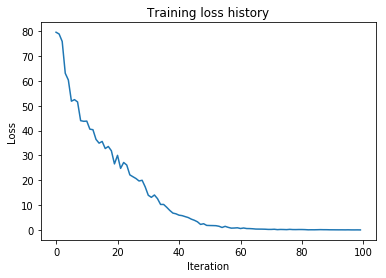

In [12]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples. As with the RNN, training results should be very good, and validation results probably won't make a lot of sense (because we're overfitting).

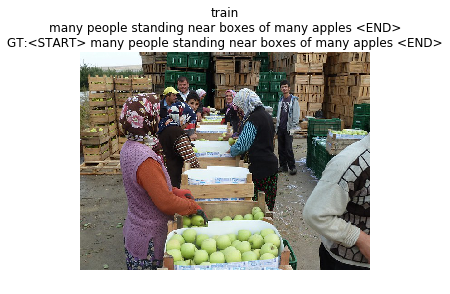

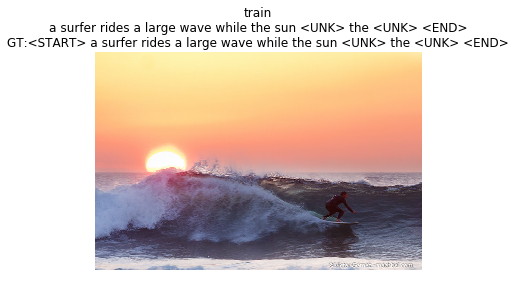

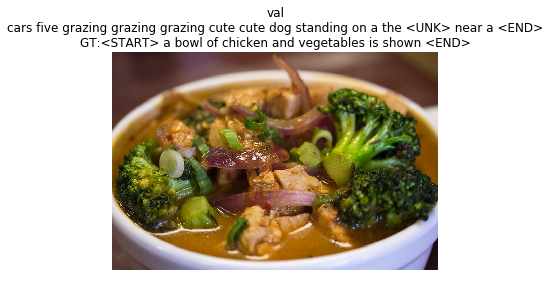

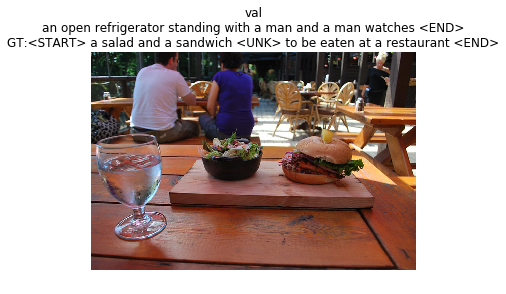

In [18]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()